In [2]:
from stackapi import StackAPI
import pandas as pd
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [64]:
print(date)
print(int(date.timestamp()))


2024-06-10 02:14:29
1717978469


In [65]:
# Configuration de l'API
SITE = StackAPI('stackoverflow')
SITE.page_size = 100 
SITE.max_pages = 10

# Définir la période (exemple : les 3 dernières années)
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)
start_date_unix = int(start_date.timestamp())

# end_date_unix = int(end_date.timestamp())
end_date_unix = 1717978469 + 1

number_of_questions = 10000

# data = []


while len(data) < number_of_questions:

    questions = SITE.fetch('questions',
                            fromdate=start_date_unix,
                            todate=end_date_unix,
                            sort='creation')

    for item in questions['items']:
        score = item.get('score', 0)
        answer_count = item.get('answer_count', 0)
        date = datetime.fromtimestamp(item['creation_date'])
        if score > 0 and answer_count > 0:
            data.append({
                'date': datetime.fromtimestamp(item['creation_date']),
                'title': item['title'],
                'tags': item['tags'],
                'score': item['score'],
                'answer_count': item['answer_count']
            })
            
    print(date)
    print(len(data))
    end_date_unix = int(date.timestamp())

# Convertir en DataFrame
df = pd.DataFrame(data)

# Afficher le DataFrame
print(df.info())
df.head()

2024-06-08 23:21:53
7905
2024-06-07 21:39:12
8089
2024-06-07 11:04:45
8226
2024-06-06 18:25:08
8398
2024-06-06 09:25:22
8571
2024-06-05 16:47:04
8740
2024-06-05 05:30:27
8913
2024-06-04 14:38:54
9075
2024-06-03 23:45:44
9247
2024-06-03 12:52:41
9398
2024-06-02 16:46:23
9568
2024-06-01 15:05:05
9744
2024-05-31 17:30:45
9892
2024-05-31 06:44:24
10046
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10046 entries, 0 to 10045
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10046 non-null  datetime64[ns]
 1   title         10046 non-null  object        
 2   tags          10046 non-null  object        
 3   score         10046 non-null  int64         
 4   answer_count  10046 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 392.6+ KB
None


,date,title,tags,score,answer_count
0,2024-07-16 21:13:48,Is it possible to use to use ssim to find diff...,"[python, histogram, ssim]",1,1
1,2024-07-16 20:54:40,Python: Converting string to integer,"[python, function, integer, string-conversion]",1,2
2,2024-07-16 20:44:16,How can I get commands in Rails Migration file...,"[ruby-on-rails, regex, ruby, migration]",1,1
3,2024-07-16 20:43:53,Why do you exclude negative numbers from a max...,[algorithm],2,1
4,2024-07-16 20:37:24,How can I filter an ISODate field based only t...,"[mongodb, mongodb-query, aggregation-framework]",2,1


In [66]:
# Identifier les titres en double
doublons_title = df[df.duplicated(subset=['title'], keep=False)]

# Group by title to see all rows with duplicate titles
grouped_doublons = doublons_title.groupby('title')

print(len(grouped_doublons))

# Afficher les différentes lignes pour chaque doublon de 'title'
for title, group in grouped_doublons:
    print(f"Title: {title}")
    print(group)
    print("\n" + "="*80 + "\n")  # Séparation entre les groupes pour plus de clarté

0


In [67]:
grouped_doublons.head()

,date,title,tags,score,answer_count


In [68]:
# # Sauvegarder le DataFrame dans un fichier CSV
df.to_csv('stackoverflow_questions.csv', index=False)

In [3]:
# Diviser les données en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Sauvegarder les DataFrames d'entraînement et de test dans des fichiers CSV
df_train.to_csv('stackoverflow_questions_train.csv', index=False)
df_test.to_csv('stackoverflow_questions_test.csv', index=False)

In [69]:
# Extraire les tags et compter leur fréquence
all_tags = [tag for tags in df['tags'] for tag in tags]
tag_counts = pd.Series(all_tags).value_counts()
top_30_tags = tag_counts.head(30).index.tolist()

# Filtrer les questions pour ne garder que celles avec les top 30 tags
df['tags'] = df['tags'].apply(lambda tags: [tag for tag in tags if tag in top_30_tags])
df = df[df['tags'].map(len) > 0]

In [70]:
# Préparer les textes pour Bag of Words et TF-IDF
vectorizer_bow = CountVectorizer(stop_words='english')
X_bow = vectorizer_bow.fit_transform(df['title'])

vectorizer_tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(df['title'])

# Afficher les résultats
print("Top 30 Tags:")
print(top_30_tags)
print("\nBag of Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)

Top 30 Tags:
['python', 'javascript', 'c#', 'r', 'c++', 'angular', 'java', 'typescript', 'reactjs', 'html', 'c', 'css', 'android', 'pandas', 'sql', 'excel', 'php', 'dataframe', 'kotlin', 'flutter', 'postgresql', 'swift', 'node.js', 'powershell', '.net', 'django', 'ios', 'android-jetpack-compose', 'go', 'numpy']

Bag of Words shape: (7109, 8535)
TF-IDF shape: (7109, 8535)


In [71]:
import numpy as np

# Afficher les premières lignes de la matrice BoW
print("Bag of Words matrix (first 5 rows):")
print(X_bow.toarray()[:5])

# Afficher les premières lignes de la matrice TF-IDF
print("TF-IDF matrix (first 5 rows):")
print(X_tfidf.toarray()[:5])

# Afficher les termes (mots uniques)
print("Feature names (first 20 words):")
print(vectorizer_bow.get_feature_names_out()[:20])

Bag of Words matrix (first 5 rows):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
TF-IDF matrix (first 5 rows):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Feature names (first 20 words):
['00' '00000' '0004' '000gb' '000x' '00997' '01' '04' '08007' '09' '0m'
 '0s' '0th' '10' '100' '1000' '10001st' '1024' '103820' '10mins']


Quelques questions:
                                                title          tags
0   Is it possible to use to use ssim to find diff...      [python]
1                Python: Converting string to integer      [python]
5   How to contract nodes and apply functions to n...      [python]
6   Should Nuget package versions match the .NET T...    [c#, .net]
7   Is GCC correct in rejecting overload between r...         [c++]
9   R: Generate an ID for multiple rows (mutate) d...           [r]
10         Why do I need to model a join table class?     [c#, sql]
11  Unable to scrape artist data from Beatport usi...  [javascript]
12  How to select specific columns across multiple...           [r]
13  What is the problem with my R code for solving...           [r]


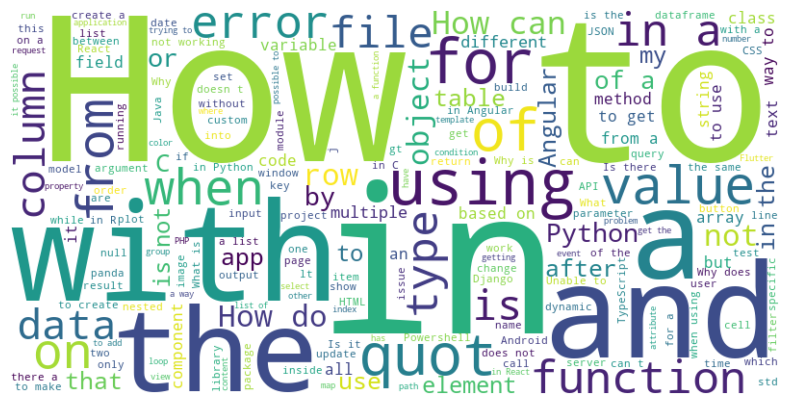

In [72]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Afficher quelques questions
print("Quelques questions:")
print(df[['title', 'tags']].head(10))

# Combiner tous les titres en un seul texte
all_titles = ' '.join(df['title'].values)

# Générer le WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(all_titles)

# Afficher le WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()